# Plot Figure 4 Monkey Decoding
### Decoding Samples Monkey behav | neural activity

In [1]:
import gc
import os
import pickle
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from maskedvae.utils.utils import load_individual_pickle, save_as_pickle
from maskedvae.plotting.plotting import cm2inch, make_col_dict_monkey, get_title_dict



fontsize=10
plt.rcParams.update({'font.size': fontsize})
plt.rcParams.update({'axes.spines.right': False})
plt.rcParams.update({'axes.spines.top': False})
plt.rcParams.update({'xtick.labelsize': fontsize})
plt.rcParams.update({'ytick.labelsize': fontsize})
plt.rcParams.update({'axes.titlesize': fontsize})
plt.rcParams.update({'axes.labelsize': fontsize})
plt.rcParams.update({'legend.fontsize': fontsize})
  
# reload the developing code 
%load_ext autoreload
%autoreload 2

# specify the directory here where runs are stored
temp_dir = "../../runs/monkey/"

maskedloss=True
new_date=False


# now read it in
with open("./R_runs_xam_poisson_xby_gnll_beta_1.txt", "r") as f:
    run_dirs = f.readlines()
run_dirs = [x.strip() for x in run_dirs] # remove \n

col_dict = make_col_dict_monkey()
title_dict = get_title_dict()

### set up dictionaries and select runs

In [2]:
dimwise = True  # dimwise scaling
cross_loss = False  # no cross loss
beta_val = 1  # vae beta
nll_beta = 0.3  # gnll beta

data_directory_fig_4 = "../../data/monkey/decoding/" 
local_dir = "../../data/monkey/"

# create the dictioniaries make dires if they dont exist
if not os.path.exists(local_dir):
    os.makedirs(local_dir)
if not os.path.exists(local_dir + "figures/"):
    os.makedirs(local_dir + "figures/")
if not os.path.exists(data_directory_fig_4):
    os.makedirs(data_directory_fig_4)


# check how many masked and all obs runs there are
count_masked = 0
count_naive = 0
for run in run_dirs:
    count_masked += 1 if "masked" in run else 0
    count_naive += 1 if "all_obs" in run else 0
print(f"count_masked: {count_masked}, count_naive: {count_naive}")

if count_naive > count_masked:
    run_dirs = run_dirs[: 2 * count_masked]


count_masked: 16, count_naive: 16


### read in all the files for plotting 

In [3]:
all_xb_d = []
all_xb_y = []
run_names = []
session_xb_d_gt = []
session_xb_y_gt = []
all_mean_decoding = []
model_tags = []
all_calibs = []

dict_names = [
    "all_xb_d",
    "all_xb_y",
    "run_names",
    "session_xb_d_gt",
    "session_xb_y_gt",
    "all_mean_decoding",
    "model_tags",
    "all_calibs",
]

load_from_scratch = False
if load_from_scratch:
    for q, run in enumerate(run_dirs):
        # load calibration dict
        with open(os.path.join(temp_dir, run, "calibration_dict.pkl"), "rb") as f:
            calibration_dict = pickle.load(f)
        with open(os.path.join(temp_dir, run, "samples.pkl"), "rb") as f:
            samples = pickle.load(f)
        with open(os.path.join(temp_dir, run, "session_data_0.pkl"), "rb") as f:
            session_data = pickle.load(f)
        with open(os.path.join(temp_dir, run, "LogL_mean_decoding.pkl"), "rb") as f:
            logL_mean_decoding = pickle.load(f)
        with open(os.path.join(temp_dir, run, "mean_decoding.pkl"), "rb") as f:
            all_mean_decoding.append(pickle.load(f))

        run_names.append(run)

        session_xb_d_gt.append(session_data["xb_d"].detach().cpu().numpy())
        session_xb_y_gt.append(session_data["xb_y"].detach().cpu().numpy())
        all_xb_d.append(samples["xb_d"])
        all_xb_y.append(samples["xb_y"])
        reduced_calib = {}
        reduced_calib["xb_y"] = calibration_dict["xb_y"]
        all_calibs.append(reduced_calib)

        if "all_obs" in run:
            model_tags.append("naive")
        elif "masked" in run:
            model_tags.append("masked")

        # delete to save memory
        del samples
        del calibration_dict
        del session_data
        gc.collect()

    gc.collect()

    # save all datav
    for file_name in dict_names:
        data = globals().get(file_name)
        if data is not None:
            save_as_pickle(data, file_name, data_directory_fig_4)
        del data
        gc.collect()
else:
    print("Loading from file...")
    # Loading all files into a dictionary
    loaded_data = {
        file_name: load_individual_pickle(file_name, data_directory_fig_4)
        for file_name in dict_names
    }

    # Dynamically create global variables from the keys of the dictionary
    for key, value in loaded_data.items():
        print(key)
        globals()[key] = value

gc.collect()

Loading from file...
all_xb_d
all_xb_y
run_names
session_xb_d_gt
session_xb_y_gt
all_mean_decoding
model_tags
all_calibs


0

# Figure 4 Panel D, E, F
### Plot mean across model seeds, samples from the model and calibration of decoded behavior

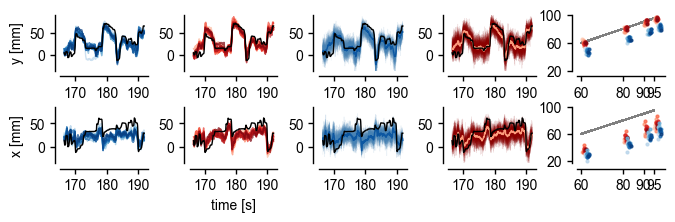

In [4]:
blues = plt.get_cmap("Blues")(np.linspace(0.2, 0.95, int(len(run_dirs) / 2)))
reds = plt.get_cmap("Reds")(np.linspace(0.2, 0.95, int(len(run_dirs) / 2)))
shift_m = {}
shift_m["masked"] = 0
shift_m["naive"] = 0
# which condition mask setting to plot (xb_yd -> behav | neural activity)
mask_string = "xb_yd"
# which behavioral variable to plot (xb_d -> speed,  xb_y -> position)
behav_var = "xb_y"
# which session to plot (if only one session 0 only possible)
session_ = 0


# specify the time steps to be plotted
t_min = 2600
t_max = 3000
fps = 15.625

# read in scale_mu and scale_std
with open(data_directory_fig_4 + "scale_mu.pkl", "rb") as f:
    scale_mu = pickle.load(f)

with open(data_directory_fig_4 + "scale_std.pkl", "rb") as f:
    scale_std = pickle.load(f)

time = np.arange(t_min, t_max) / fps

# specify ylims according to the behavioral variable
ylims = {}
if behav_var == "xb_d":
    ylims["x"] = [-7.5, 4]
    ylims["y"] = [-2.5, 4.2]
elif behav_var == "xb_y":
    ylims["x"] = [-35, 85]
    ylims["y"] = [-35, 90]

# specify the index of the subplot
dict_index = {
    "xnaivemean": [1, 0],
    "ynaivemean": [0, 0],
    "xmaskedmean": [1, 1],
    "ymaskedmean": [0, 1],
    "xnaivesample": [1, 2],
    "ynaivesample": [0, 2],
    "xmaskedsample": [1, 3],
    "ymaskedsample": [0, 3],
}

# ------------------ Set up the figure  ------------------

fig, axes = plt.subplots(2, 5, figsize=cm2inch((17, 5.5)), sharex=False)
plt.rcParams.update({"font.family": "Arial"})
# Manually link the x-axes of subplots, excluding axes[0, 4] and axes[1, 4]
for i in range(2):  # Loop over rows
    for j in range(4):  # Loop over the first four columns
        axes[i, j].sharex(axes[i, 0])


# share y axis only rowwise for these plots
for j in range(4):  # Loop over the first four columns
    axes[0, j].sharey(axes[0, 0])
    axes[1, j].sharey(axes[1, 0])
# --------------------------------------------------------


# plot the mean over many seeds 
count_idx = 0
for x_index, xx in enumerate(
    [
        "x",
        "y",
    ]
):
    for tag in ["naive", "masked"]:
        axs = axes[dict_index[xx + tag + "mean"][0], dict_index[xx + tag + "mean"][1]]
        naiveflag = True
        for mask_key in [
            "xb_yd",
        ]:
            for q, mean_decoding in enumerate(all_mean_decoding):
                if model_tags[q] == tag:
                    axs.plot(
                        time,
                        scale_mu[xx]
                        + np.array(
                            mean_decoding[behav_var][model_tags[q]][mask_key][session_]
                        )[0, x_index, t_min:t_max]
                        / scale_std[xx],
                        alpha=0.7,
                        color=(
                            blues[q - int(len(run_dirs) / 2)]
                            if model_tags[q] == "naive"
                            else reds[q]
                        ),
                        label=str(q),
                    )
            if behav_var == "xb_d":
                axs.plot(
                    time,
                    session_xb_d_gt[q][0, x_index, t_min:t_max],
                    color="k",
                    label="true",
                )
            elif behav_var == "xb_y":
                axs.plot(
                    time,
                    scale_mu[xx]
                    + session_xb_y_gt[q][0, x_index, t_min:t_max] / scale_std[xx],
                    color="k",
                    label="true",
                )
            axs.spines["left"].set_position(("outward", 4))
            axs.spines["bottom"].set_position(("outward", 4))
            axs.set_ylim(ylims[xx])
            count_idx += 1


# plot the samples for a selected seed
for x_index, xx in enumerate(["x", "y"]):
    for q, samples_xb in enumerate(all_xb_d if behav_var == "xb_d" else all_xb_y):
        for mask_key in [
            "xb_yd",
        ]:
            if q == 3 or q == 29:

                scaled_samples = (
                    scale_mu[xx]
                    + (
                        np.array(samples_xb[model_tags[q]][mask_key][session_])[
                            :, x_index, t_min:t_max
                        ].T
                    )
                    / scale_std[xx]
                )
                # compute confidence interval per time step
                conf_int = np.zeros((scaled_samples.shape[0], 3))

                for t in range(scaled_samples.shape[0]):
                    conf_int[t, 0] = np.quantile(scaled_samples[t, :], 0.025)
                    conf_int[t, 1] = np.quantile(scaled_samples[t, :], 0.975)
                    conf_int[t, 2] = np.quantile(scaled_samples[t, :], 0.5)  # median

                axs = axes[
                    dict_index[xx + model_tags[q] + "sample"][0],
                    dict_index[xx + model_tags[q] + "sample"][1],
                ]

                axs.plot(
                    time,
                    scale_mu[xx]
                    + (
                        np.array(samples_xb[model_tags[q]][mask_key][session_])[
                            :, x_index, t_min:t_max
                        ].T
                    )
                    / scale_std[xx],
                    "-",
                    alpha=0.1,
                    lw=0.5,
                    color="steelblue" if model_tags[q] == "naive" else "darkred",
                    label="samples",
                )
                axs.plot(
                    time,
                    scale_mu[xx]
                    + np.array(
                        all_mean_decoding[q][behav_var][model_tags[q]][mask_key][
                            session_
                        ]
                    )[0, x_index, t_min:t_max]
                    / scale_std[xx],
                    alpha=1,
                    color=(
                        blues[q - int(len(run_dirs) / 2)]
                        if model_tags[q] == "naive"
                        else reds[q]
                    ),
                    label="mean recon",
                )
                if behav_var == "xb_d":
                    axs.plot(
                        time,
                        session_xb_d_gt[q][0, x_index, t_min:t_max],
                        color="k",
                        label="true",
                    )
                elif behav_var == "xb_y":
                    axs.plot(
                        time,
                        scale_mu[xx]
                        + session_xb_y_gt[q][0, x_index, t_min:t_max] / scale_std[xx],
                        color="k",
                        label="true",
                    )
                axs.spines["left"].set_position(("outward", 4))
                axs.spines["bottom"].set_position(("outward", 4))
                # only take unique labels
                handles, labels = plt.gca().get_legend_handles_labels()
                axs.set_ylim(ylims[xx])


axes[1, 1].set_xlabel("time [s]")
axes[1, 0].set_ylabel("x [mm]")
axes[0, 0].set_ylabel("y [mm]")

# plot calibration
percentile_label = [95, 90, 80, 60]
# Loop through mask keys
for mask_key in [mask_string]:
    for q, calib in enumerate(all_calibs):
        for percentile in percentile_label:
            rand = 1 * np.random.rand()
            for vid, x_index in enumerate([1, 0]):
                axes[vid, 4].plot(
                    shift_m[model_tags[q]] + q * 0.1 + rand + percentile,
                    100
                    * all_calibs[q][behav_var][model_tags[q]][mask_key][session_][
                        percentile
                    ][x_index],
                    ".",
                    ms=4,
                    alpha=0.8,
                    color=(
                        blues[q - int(len(run_dirs) / 2)]
                        if model_tags[q] == "naive"
                        else reds[q]
                    ),
                )

                # Customize the ax4 subplot
                # send all the way to the back
                axes[vid, 4].plot(percentile_label, percentile_label, "grey", zorder=-1)
                axes[vid, 4].spines["left"].set_position(("outward", 4))
                axes[vid, 4].spines["bottom"].set_position(("outward", 4))
                axes[vid, 4].spines["top"].set_visible(False)
                axes[vid, 4].spines["right"].set_visible(False)
                axes[vid, 4].set_xticks(percentile_label)
                axes[vid, 4].set_yticks([20, 60, 100])

plt.tight_layout(pad=0.5, w_pad=0.1, h_pad=0.1)
file_name = f"Fig_4_traces_monkey_decoding_all_seeds_mean_decoding_mask_{mask_key}_{behav_var}_{tag}_samples_and_calibration_small"
plt.savefig(f"{local_dir}/figures/{file_name}.pdf", bbox_inches="tight")
plt.savefig(f"{local_dir}/figures/{file_name}.png", bbox_inches="tight")


# Figure 4 Panel B & C
### Raches over the 8x8 grid and distribution of spike counts per neuron per time bin

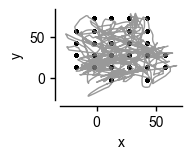

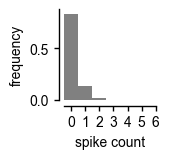

In [5]:
# load
data_dir = "../../data/monkey/"
with open(data_dir + "/PD_test.pkl", "rb") as f:
    PD_test = pickle.load(f)

# plot the continuous reaches

plt.figure(figsize=cm2inch((4, 3)))
plt.plot(
    PD_test.target_pos[0][0, :],
    PD_test.target_pos[0][1, :],
    "o",
    ms=2,
    color="black",
    alpha=0.8,
)
plt.plot(
    PD_test.cursor_pos[0][0, :],
    PD_test.cursor_pos[0][1, :],
    color="grey",
    alpha=0.8,
    lw=1,
)
plt.xlabel("x")
plt.ylabel("y")

# move axes outwards
plt.gca().spines["left"].set_position(("outward", 4))
plt.gca().spines["bottom"].set_position(("outward", 4))
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

plt.savefig(f"{local_dir}/figures/reaches_test.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{local_dir}/figures/reaches_test.pdf", dpi=300, bbox_inches="tight")

# plot the spike count distribution
top = 8
plt.figure(figsize=cm2inch((3, 3)))
bins = np.linspace(-0.5, top - 1.5, top)
plt.hist(
    PD_test.get_session(0)["xa_m"][0, :, :].flatten(),
    bins=bins,
    color="grey",
    density=True,
)
plt.xlabel("spike count")
plt.ylabel("frequency")
plt.xticks(np.arange(0, top - 1, 1))
# get rid of right and top spines
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_position(("outward", 4))
plt.gca().spines["bottom"].set_position(("outward", 4))
plt.xlim([-0.5, 6])

plt.savefig(f"{local_dir}/figures/spike_count_dist.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{local_dir}/figures/spike_count_dist.pdf", dpi=300, bbox_inches="tight")